In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

#for VADER
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.downloader.download('vader_lexicon')

#for roberta
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [16]:
#read data from google drive
df = pd.read_csv('/content/Reviews.csv')
print(df.shape)

#we are only taking first 500 reviews for now
df = df.head(500)
print(df.shape)

(568454, 10)
(500, 10)


In [28]:
#example review for testing purposes
example = df['Text'][30]
print(example)

I have never been a huge coffee fan. However, my mother purchased this little machine and talked me into trying the Latte Macciato. No Coffee Shop has a better one and I like most of the other products, too (as a usually non-coffee drinker!).<br />The little Dolche Guesto Machine is super easy to use and prepares a really good Coffee/Latte/Cappuccino/etc in less than a minute (if water is heated up). I would recommend the Dolce Gusto to anyone. Too good for the price and I'am getting one myself! :)


#**EDA**#

In [18]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


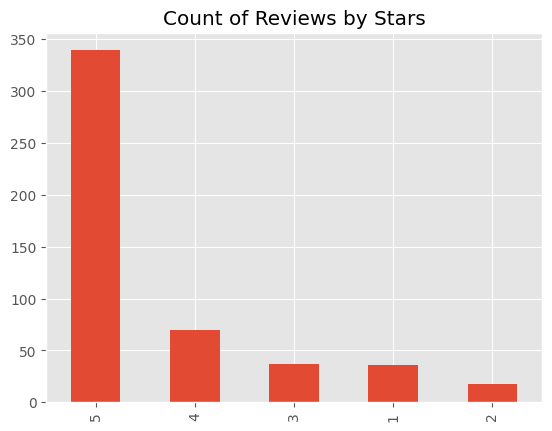

In [19]:
df['Score'].value_counts().plot(kind='bar',
          title='Count of Reviews by Stars')
plt.show()

#**VADER**#

In [22]:
sia = SentimentIntensityAnalyzer()

In [24]:
sia.polarity_scores('This is so good!')

{'neg': 0.0, 'neu': 0.427, 'pos': 0.573, 'compound': 0.6166}

In [25]:
sia.polarity_scores('This is the worst day ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [29]:
#running polarity score from the review we took as example
print(example)
sia.polarity_scores(example)

I have never been a huge coffee fan. However, my mother purchased this little machine and talked me into trying the Latte Macciato. No Coffee Shop has a better one and I like most of the other products, too (as a usually non-coffee drinker!).<br />The little Dolche Guesto Machine is super easy to use and prepares a really good Coffee/Latte/Cappuccino/etc in less than a minute (if water is heated up). I would recommend the Dolce Gusto to anyone. Too good for the price and I'am getting one myself! :)


{'neg': 0.041, 'neu': 0.692, 'pos': 0.267, 'compound': 0.9713}

In [30]:
#run this analyzer on the dataset
results = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    id = row['Id']
    results[id] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [33]:
#print results
dataframe = pd.DataFrame(results).T
print(dataframe.head)

<bound method NDFrame.head of        neg    neu    pos  compound
1    0.000  0.695  0.305    0.9441
2    0.138  0.862  0.000   -0.5664
3    0.091  0.754  0.155    0.8265
4    0.000  1.000  0.000    0.0000
5    0.000  0.552  0.448    0.9468
..     ...    ...    ...       ...
496  0.000  0.554  0.446    0.9725
497  0.059  0.799  0.142    0.7833
498  0.025  0.762  0.212    0.9848
499  0.041  0.904  0.055    0.1280
500  0.000  0.678  0.322    0.9811

[500 rows x 4 columns]>


#**Roberta**#


In [34]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [37]:
encoding_example = tokenizer(example, return_tensors='pt')
output = model(**encoding_example)
score = output[0][0].detach().numpy()
scores = softmax(score)
scores_dict = {
    'r_neg' : scores[0],
    'r_neu' : scores[1],
    'r_pos' : scores[2]
}
print(example)
#roberta is much better at coreectly classifying this as a positive review which vader couldnt recognize
print(scores_dict)

I have never been a huge coffee fan. However, my mother purchased this little machine and talked me into trying the Latte Macciato. No Coffee Shop has a better one and I like most of the other products, too (as a usually non-coffee drinker!).<br />The little Dolche Guesto Machine is super easy to use and prepares a really good Coffee/Latte/Cappuccino/etc in less than a minute (if water is heated up). I would recommend the Dolce Gusto to anyone. Too good for the price and I'am getting one myself! :)
{'r_neg': 0.0024305165, 'r_neu': 0.016508142, 'r_pos': 0.98106134}


In [43]:
#generate scores for the whole text
results_r = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
  try:
      text = row['Text']
      id = row['Id']
      encode = tokenizer(text, return_tensors='pt')
      output = model(**encode)
      score = output[0][0].detach().numpy()
      scores = softmax(score)
      scores_dict = {
          'r_neg' : scores[0],
          'r_neu' : scores[1],
          'r_pos' : scores[2]
      }
      results_r[id] = scores_dict
  except:
    pass

  0%|          | 0/500 [00:00<?, ?it/s]

In [44]:
dataframe_roberta = pd.DataFrame(results_r).T
print(dataframe_roberta.head)

<bound method NDFrame.head of         r_neg     r_neu     r_pos
1    0.009624  0.049980  0.940395
2    0.508986  0.452414  0.038600
3    0.003229  0.098067  0.898704
4    0.002295  0.090219  0.907486
5    0.001635  0.010302  0.988063
..        ...       ...       ...
496  0.001906  0.009862  0.988232
497  0.004415  0.034215  0.961369
498  0.006427  0.074537  0.919036
499  0.865614  0.119366  0.015020
500  0.002440  0.011327  0.986233

[498 rows x 3 columns]>
